In [78]:
from PIL import Image
import os
import numpy as np
import matplotlib.pyplot as plt
from skimage.feature import hog
import pickle

In [100]:
with open("pickles/combined_model.pkl", 'rb') as f:
    model= pickle.load(f)

def get_feature_vector(image, grid_q= 4, no_orientation= 8):
    if type(grid_q)== np.ndarray: # ndarray path
        hog_features= []
        for gq in grid_q:
            hf= get_feature_vector(image, grid_q= gq, no_orientation= no_orientation)
            hog_features= np.append(hog_features, hf)
    else: # integer path
        ppc = (int(image.shape[0]/grid_q), int(image.shape[1]/grid_q))
        hog_features = hog(image, orientations= no_orientation, pixels_per_cell= (int(image.shape[0]/grid_q), int(image.shape[1]/grid_q)),
                        cells_per_block=(1, 1), feature_vector= True)
    return hog_features

def get_image(image_path):
    image = Image.open(image_path)
    image = image.convert('L')
    return image

def slice_image(image, voxel_size):
    image_width, image_height = image.size
    sliced_list= []
    pos_list= np.empty((0, 2))

    for y in range(0, image_height-voxel_size+1, voxel_size):
        for x in range(0, image_width-voxel_size+1, voxel_size):
            box = (x, y, x + voxel_size, y + voxel_size)
            voxel = image.crop(box)
            sliced_list.append(voxel)
            pos_list= np.append(pos_list, [x, y])

    return sliced_list, pos_list.reshape((-1, 2))

def check_image(image):
    img = np.array(image)
    if np.mean(img) < .05*256 or np.mean(img) > .95*256:
        return False
    return True

def get_orientation_map(voxel_list, pos_list):
    angle_list = []
    x= pos_list[:, 0] + VOXEL_SIZE / 2
    y= pos_list[:, 1] + VOXEL_SIZE / 2
    u, v = [], []
    valid_count, invalid_count= 0, 0
    for voxel in voxel_list:
        if check_image(voxel):
            feature_vector= get_feature_vector(np.array(voxel), GRIDQ).reshape(1, -1)
            angle= model.predict(feature_vector)[0] * (np.pi/180)
            angle_list.append(angle)
            u.append(np.cos(angle))
            v.append(np.sin(angle))
            valid_count += 1
        else:
            angle_list.append(None)
            u.append(0)
            v.append(0)
            invalid_count += 1
    return x, y, u, v, angle_list, (valid_count, invalid_count)

def plot_map(image, img_name, x, y, u, v, counts):
    plt.figure(figsize= (8, 8))
    plt.imshow(image, cmap= "gray")
    plt.quiver(x, y, u, v, color= "yellow", pivot= "middle")
    
    plt.axis("off")
    plt.title(f"Img: {img_name} | Valid voxel rate: {counts[0]} / {counts[0]+counts[1]} ", fontsize= 7)

GRIDQ= np.arange(1, 6)
# GRIDQ= np.arange(1, 4)

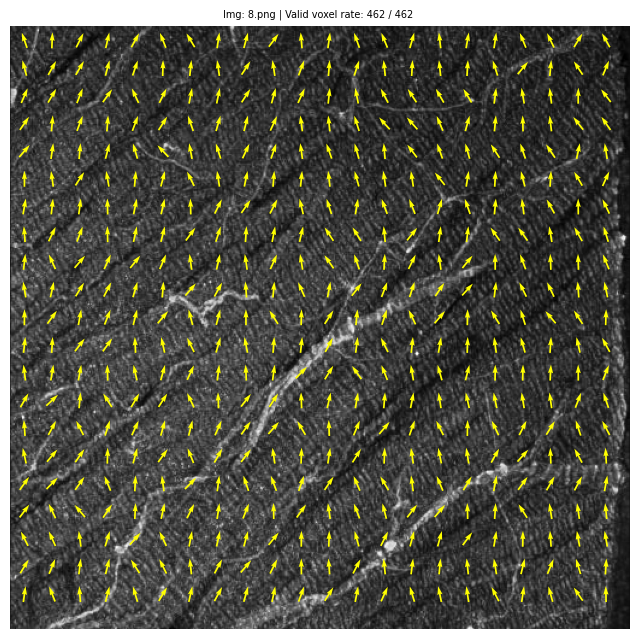

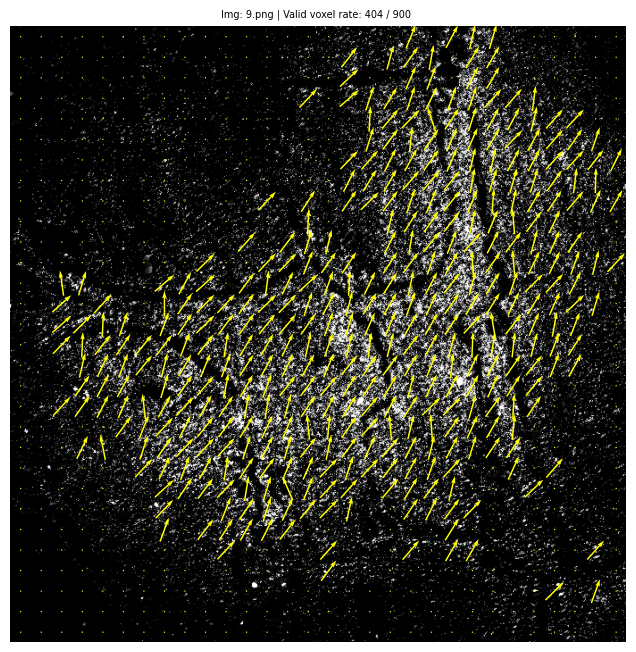

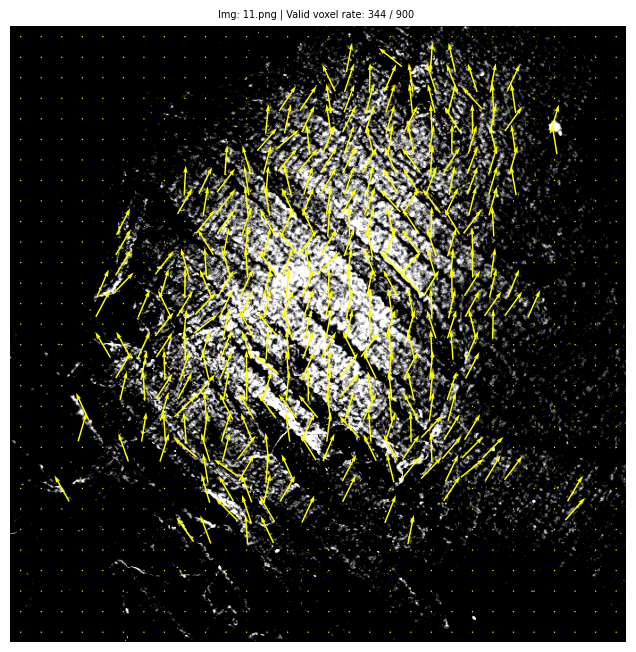

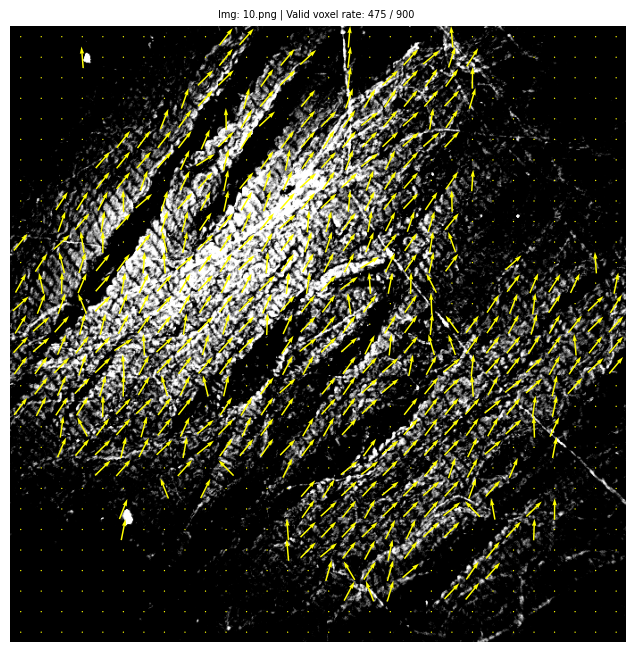

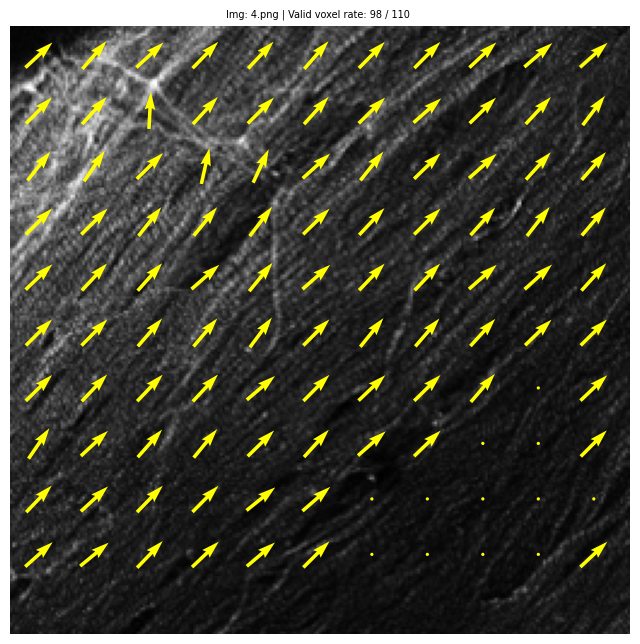

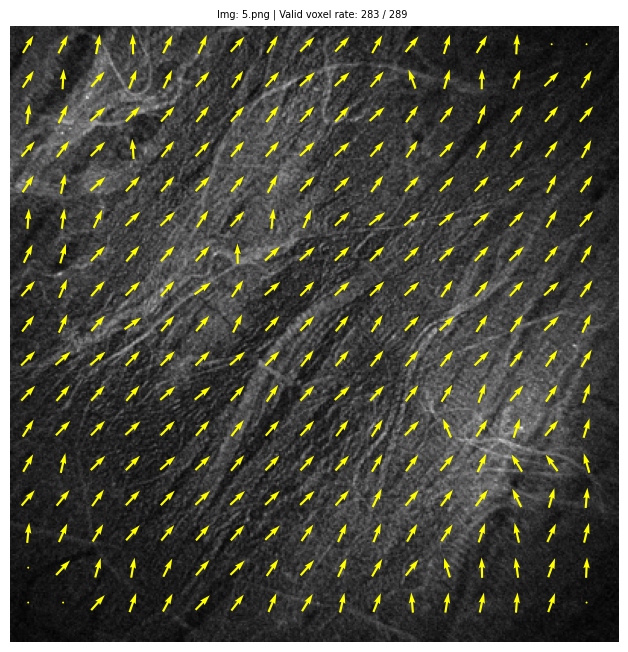

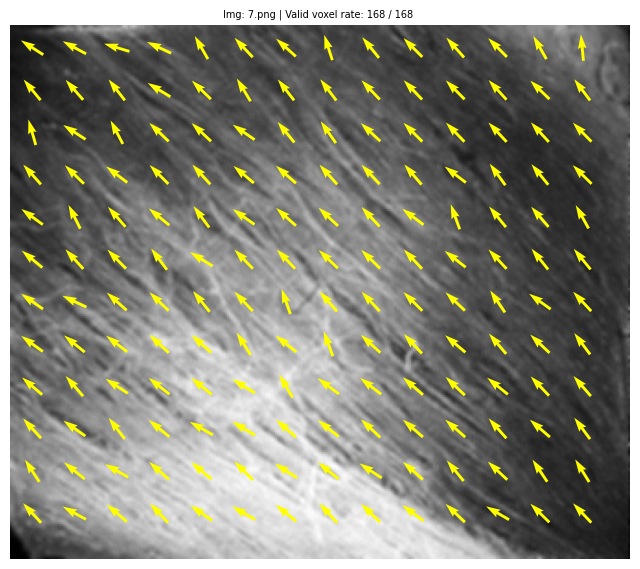

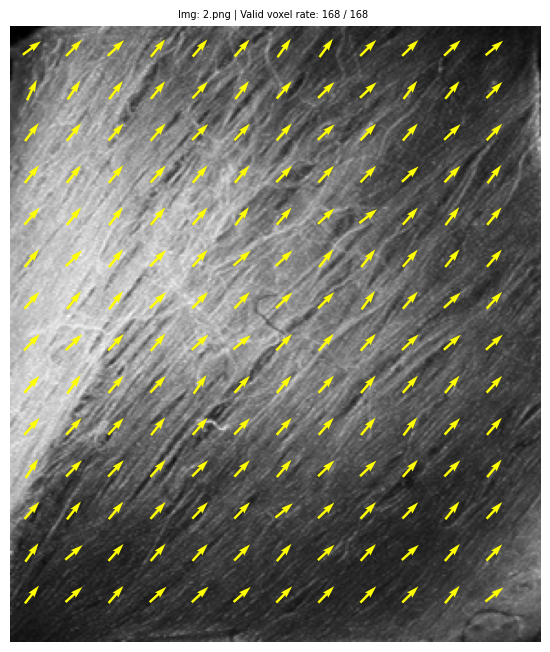

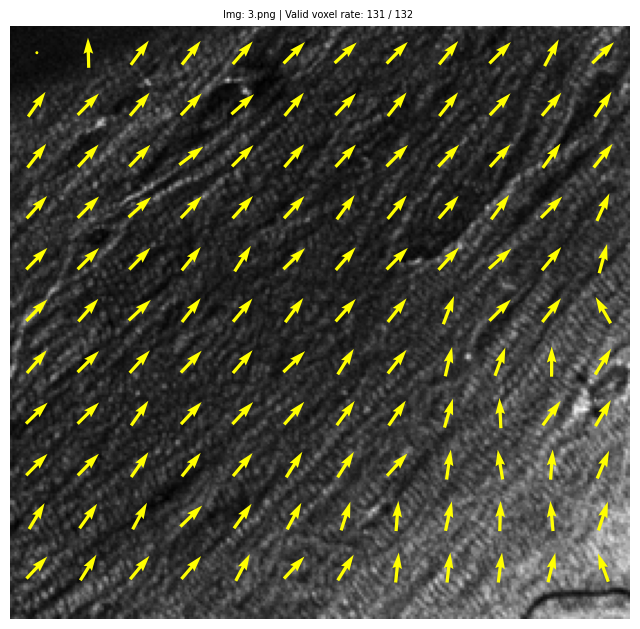

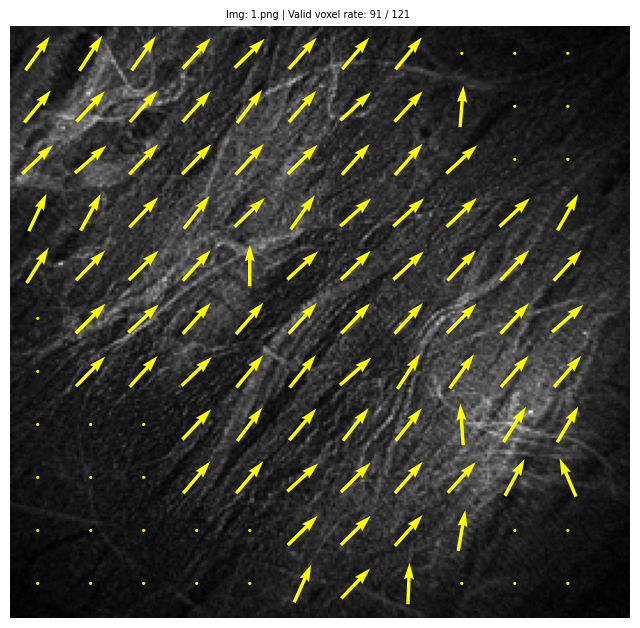

In [104]:
VOXEL_SIZE= 23

file_dir= "./images/por_image/"
file_list= [file for file in os.listdir(file_dir) if file.endswith(".png")]
for img_name in file_list:
    img_dir= file_dir + img_name
    image = get_image(img_dir)
    voxel_list, pos_list = slice_image(image, VOXEL_SIZE)
    x, y, u, v, angle_list, counts = get_orientation_map(voxel_list, pos_list)
    plot_map(image, img_name, x, y, u, v, counts)


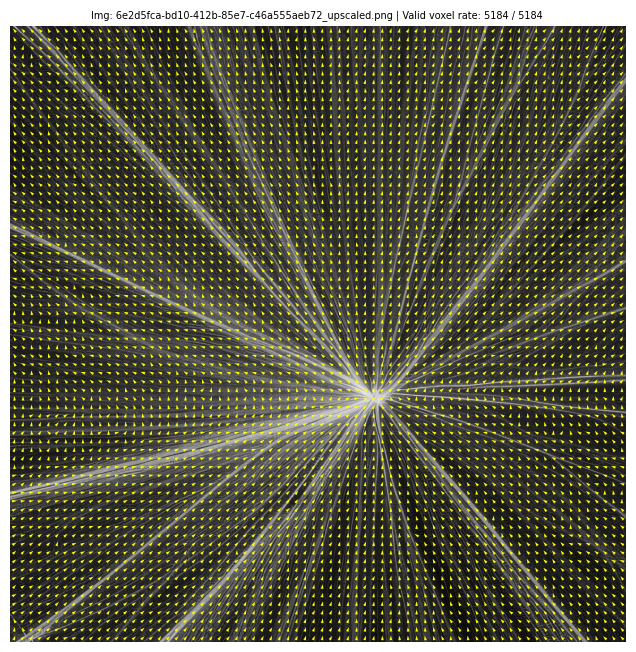

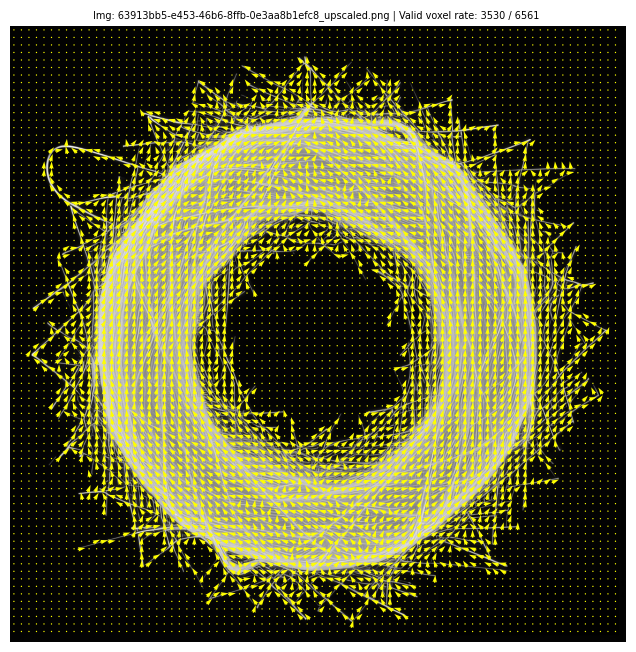

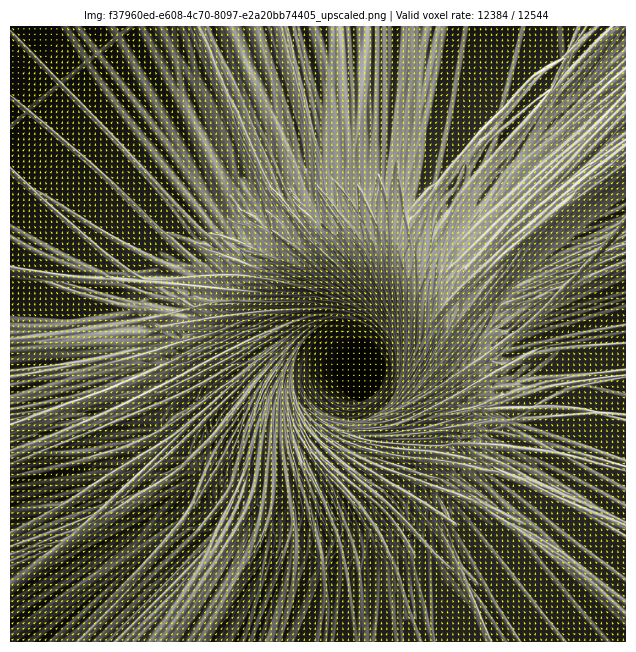

In [106]:
VOXEL_SIZE= 25
file_dir= "images/diffusion/Big/"
file_list= ["6e2d5fca-bd10-412b-85e7-c46a555aeb72_upscaled.png", "63913bb5-e453-46b6-8ffb-0e3aa8b1efc8_upscaled.png", "f37960ed-e608-4c70-8097-e2a20bb74405_upscaled.png"]

for img_name in file_list:
    img_dir= file_dir + img_name
    image = get_image(img_dir)
    voxel_list, pos_list = slice_image(image, VOXEL_SIZE)
    x, y, u, v, angle_list, counts = get_orientation_map(voxel_list, pos_list)
    plot_map(image, img_name, x, y, u, v, counts)

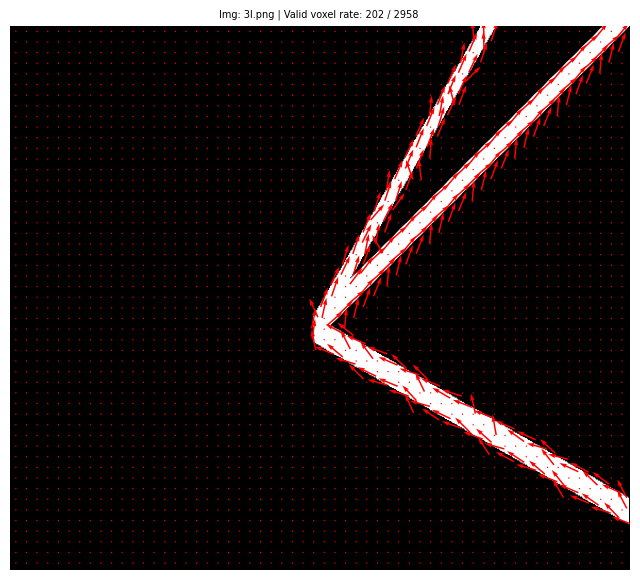

In [87]:
VOXEL_SIZE= 10
file_dir= "images/test_samples/"
file_list= ["3l.png"]

for img_name in file_list:
    img_dir= file_dir + img_name
    image = get_image(img_dir)
    voxel_list, pos_list = slice_image(image, VOXEL_SIZE)
    x, y, u, v, angle_list, counts = get_orientation_map(voxel_list, pos_list)
    plot_map(image, img_name, x, y, u, v, counts)

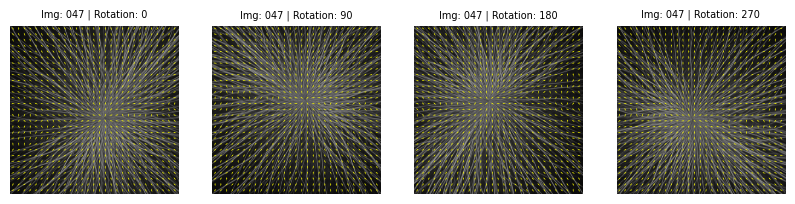

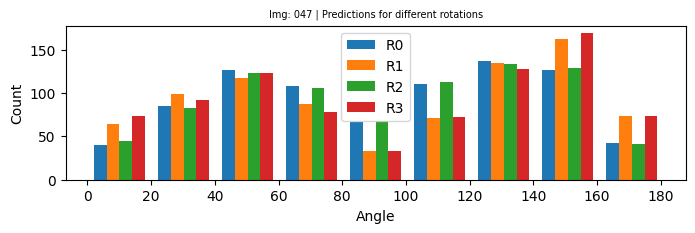

In [83]:
VOXEL_SIZE= 48
VOXEL_SIZE= 96
file_dir= "images/diffusion/Big/"
file_list= ["63913bb5-e453-46b6-8ffb-0e3aa8b1efc8_upscaled.png", "f37960ed-e608-4c70-8097-e2a20bb74405_upscaled.png"]
file_list= [file for file in os.listdir(file_dir) if file.endswith(".png")]
file_list= [file for file in os.listdir(file_dir) if file.endswith(".png")][4:5]

for img_name in file_list:
    img_dir= file_dir + img_name
    image = get_image(img_dir)
    angle_array = []
    no_rotatation = 4
    fig, axs = plt.subplots(1, no_rotatation, figsize=(10, 8))
    for i in range(no_rotatation):
        rot_image = image.rotate(90*i)
        voxel_list, pos_list = slice_image(rot_image, VOXEL_SIZE)
        x, y, u, v, angle_list, counts = get_orientation_map(voxel_list, pos_list)

        filtered_angle_list = [((180*angle/np.pi)+90*i)%180 for angle in angle_list if angle != None]
        angle_array.append(filtered_angle_list)
        
        plt.subplot(1, no_rotatation, i+1)
        plt.imshow(rot_image, cmap="gray")
        plt.quiver(x, y, u, v, color="yellow", pivot="middle")
        
        plt.axis("off")
        plt.title(f"Img: {img_name[:3]} | Rotation: {90*i}", fontsize= 7)
    
    plt.figure(figsize=(8,2))
    plt.hist(angle_array, bins=9, range=(0, 181), align="mid")
    plt.xticks(np.arange(0, 181, 20))
    plt.legend([f"R{ix}" for ix in range(no_rotatation)])
    plt.xlabel("Angle")
    plt.ylabel("Count")
    plt.title(f"Img: {img_name[:3]} | Predictions for different rotations", fontsize= 7)


In [84]:
def plot_map(image, img_name, x, y, u, v, counts):
    plt.figure(figsize= (8, 8))
    plt.imshow(image, cmap= "gray")
    plt.quiver(x, y, u, v, color= "red", pivot= "middle", scale=30)
    
    plt.axis("off")
    plt.title(f"Img: {img_name} | Valid voxel rate: {counts[0]} / {counts[0]+counts[1]} ", fontsize= 7)

array([  5.,  15.,  25., ..., 875., 885., 895.])

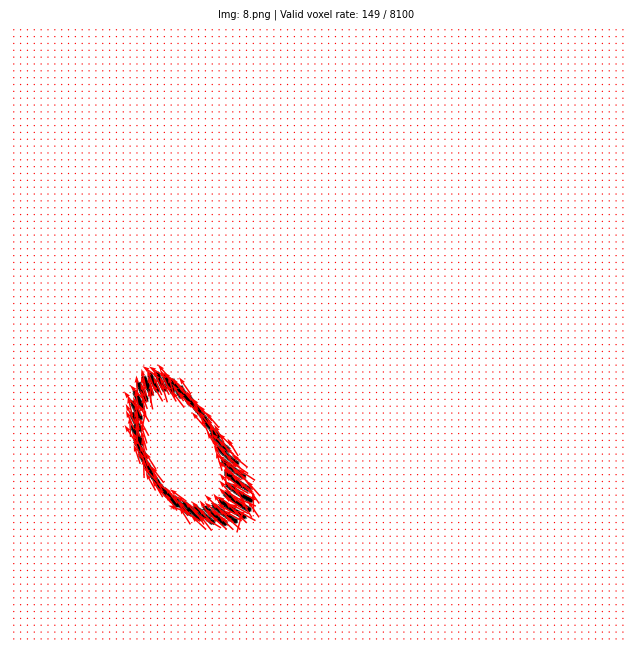

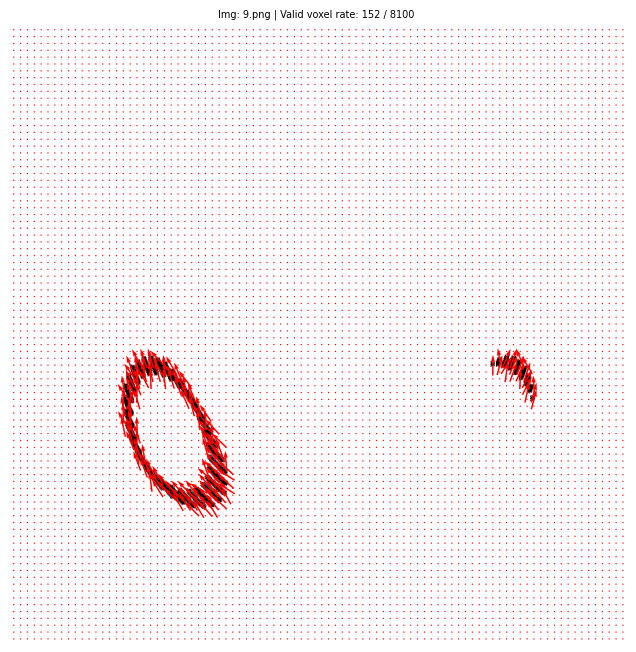

In [90]:
VOXEL_SIZE= 10
file_dir= "images/test_samples/XY/"
file_list= [file for file in os.listdir(file_dir) if file.endswith(".png")][:2]

for img_name in file_list:
    img_dir= file_dir + img_name
    image = get_image(img_dir)
    voxel_list, pos_list = slice_image(image, VOXEL_SIZE)
    x, y, u, v, angle_list, counts = get_orientation_map(voxel_list, pos_list)
    plot_map(image, img_name, x, y, u, v, counts)
x